In [1]:
%config IPCompleter.greedy=True

import os
import tifffile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
import json


/home/matt/anaconda3/envs/AudioDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matt/anaconda3/envs/AudioDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matt/anaconda3/envs/AudioDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matt/anaconda3/envs/AudioDL/lib/python3.6/s

# Load Data and Train-Test Split

In [364]:
with open("../Genre_Track_Id_Dict.json",'r') as j:
    id_genre_dict = json.load(j)
numerical_labels = dict(zip(list(id_genre_dict.keys()),np.arange(0,8)))

df = pd.DataFrame({'track_id':[],'genre':[]})
for genre,fname_list in id_genre_dict.items():
    genres = [genre]*len(fname_list)
    df = df.append(pd.DataFrame({'track_id':fname_list,'genre':genres}))
df = df.sample(frac=1) #shuffle


In [365]:
data = np.zeros((8000,128,647))
labels = np.zeros((8000,len(numerical_labels)))
ct=-1
for i,row in df.iterrows():
    track_name = row['track_id']
    spectrogram_name = '{}_mel_spect_db.tiff'.format(track_name.split('.')[0])
    genre = row['genre']
    file = os.path.join('../mp3_files',genre,spectrogram_name)
    if os.path.exists(file):
        spect = tifffile.imread(file)
        if spect.shape[1] == 646:
            spect = np.hstack((spect,np.zeros((128,1))))
        if spect.shape[1] == 647:
            ct+=1
            data[ct,:,:] = spect
            genre = row['genre']
            genre_encode = numerical_labels[genre] 
            labels[ct][genre_encode] = 1
        
data = data[0:ct,:,:]
labels = labels[0:ct,:]

data = data/-80

In [366]:
ind = int(0.8*len(labels))
X_train = data[0:ind,:,:]
y_train = labels[0:ind,:]
X_test = data[ind:,:,:]
y_test = labels[ind:,:]
X_train = X_train.reshape(X_train.shape[0], 128, 647, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 647, 1)

print("Training Shape: {} ... {}".format(X_train.shape,y_train.shape))
print("Testing Shape: {} ... {}".format(X_test.shape,y_test.shape))

Training Shape: (6394, 128, 647, 1) ... (6394, 8)
Testing Shape: (1599, 128, 647, 1) ... (1599, 8)


# Create Simple CNN

In [367]:
# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,647,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(32, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(8, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)


Train on 6394 samples, validate on 1599 samples
Epoch 1/15
6394/6394 [==============================]6394/6394 [==============================] - 122s 19ms/step - loss: 1.9432 - acc: 0.2246 - val_loss: 1.8163 - val_acc: 0.2670

Epoch 2/15
6394/6394 [==============================]6394/6394 [==============================] - 121s 19ms/step - loss: 1.7707 - acc: 0.3201 - val_loss: 1.6521 - val_acc: 0.3871

Epoch 3/15
6394/6394 [==============================]6394/6394 [==============================] - 121s 19ms/step - loss: 1.6843 - acc: 0.3677 - val_loss: 1.6403 - val_acc: 0.3977

Epoch 4/15
6394/6394 [==============================]6394/6394 [==============================] - 124s 19ms/step - loss: 1.6312 - acc: 0.3890 - val_loss: 1.5665 - val_acc: 0.4228

Epoch 5/15
6394/6394 [==============================]6394/6394 [==============================] - 132s 21ms/step - loss: 1.5830 - acc: 0.4094 - val_loss: 1.5539 - val_acc: 0.4309

Epoch 6/15
6394/6394 [==============================

In [355]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 126, 642, 16)      304       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 63, 214, 16)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 61, 212, 16)       2320      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 30, 53, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 25440)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                814112    
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
__________

# Check Model Performance
#### Seems to be overfitting. After parameter tuning seems like we need more data. 

#### Going to try augmenting audio data and mel-spectrograms. See AudioAugmentation.ipynb for reference

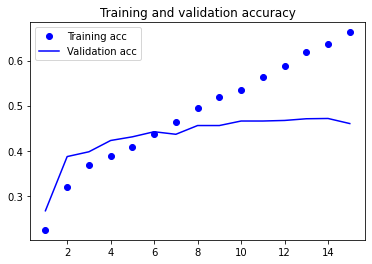

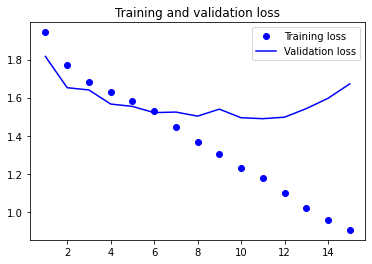

In [368]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1599/1599 [==============================]1599/1599 [==============================] - 9s 6ms/step



Text(0.5, 1.0, 'Mean Accuracy = 46%')

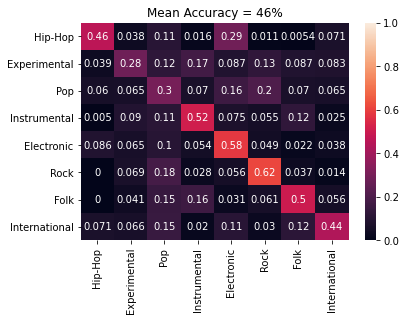

In [370]:
predictions = cnn_model.predict(X_test, verbose=1)

conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1),normalize='true')
acc = accuracy_score(np.argmax(y_test, 1), np.argmax(predictions, 1))
f,a = plt.gcf(),plt.gca()
sns.heatmap(conf_matrix,vmax=1,annot=True)
a.set_xticklabels(list(numerical_labels.keys()),rotation=90)
a.set_yticklabels(list(numerical_labels.keys()),rotation=0)
a.set_title("Mean Accuracy = {}%".format(round(100*acc),4))